In [1]:
from network_strip import DMTSNet #stsp and fixed (same but no x+u) networks
from task_strip import DMTSDataModule #spatial version, distraction code removed
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #fix for weird issue where matplotlib kills  kernel

In [3]:
#load data generator
dt_ann = 15
DMTS = DMTSDataModule(dt_ann = dt_ann)  
DMTS.setup()
tester = DMTS.test_dataloader()
inp, out_des,y,test_on = next(iter(tester))

# load model and get output from test data
ckpt_dir = r"D:\robust_wm_stsp\Robust_WM_STSP_Modelling\robust_wm_stsp\stripped\_lightning_sandbox\checkpoints"
model = DMTSNet.load_from_checkpoint(os.path.join(ckpt_dir, ckpt))
out_readout, out_hidden, w_hidden, _ = model(inp)

In [10]:
samp_on = int(1000/dt_ann)
unique_delay_times = torch.unique(test_on)
num_delays = len(unique_delay_times)
num_samps = 2

delay: 2.49, 206 trials, accuracy: 0.9998528979111503
delay: 2.91, 213 trials, accuracy: 0.998719590268886
delay: 3.495, 196 trials, accuracy: 0.9984539270253555
delay: 4.32, 202 trials, accuracy: 0.998049804980498
delay: 5.49, 207 trials, accuracy: 0.993705167618211


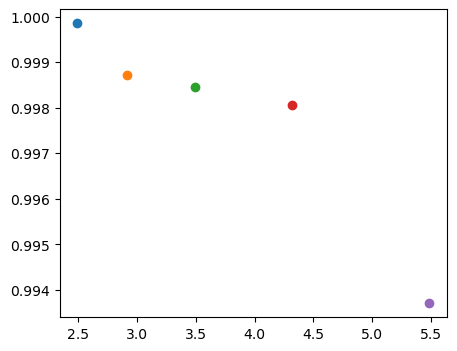

In [7]:
#plot mean accuracy at each delay length
acc_dict = {}
plt.figure(figsize=(5,4))

for delay in unique_delay_times:
    
    #get trials with same delay length
    delay_inds = torch.where(test_on == delay)[0]
    accs = np.zeros(len(delay_inds))
    
    for i,trial in enumerate(delay_inds):
        
        #count of number of times NN made right choice during post-test window +divide by num timepoints
        curr_max = out_readout[trial,int(test_on[trial])+int(500/model.dt_ann):int(test_on[trial])+2*int(500/model.dt_ann),:-1].argmax(dim = 1).cpu().detach().numpy()
        accs[i] = (y[trial].item() == curr_max).sum() / len(curr_max)
        
    acc_dict[(delay.item()*15)/1000] = accs
    #average single-trial accuracy across entire test set (1024 trials) and plot as function of delay
    print(f"delay: {(delay.item()*15)/1000}, {len(delay_inds)} trials, accuracy: {accs.mean()}")
    plt.scatter((delay.item()*15)/1000, accs.mean())
# plt.ylim([.3,.7])
plt.show()

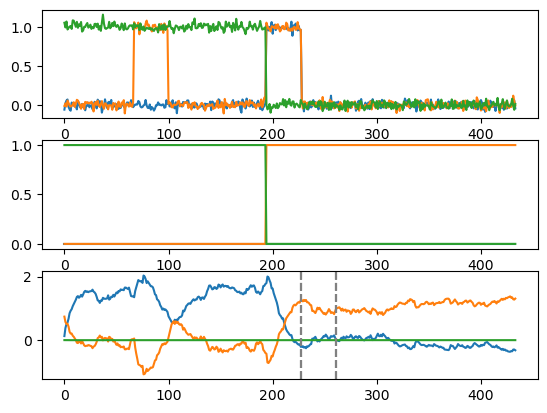

In [8]:
#check inputs, desired outputs, and actual outputs for one trial at a time
trial = 4
f,ax = plt.subplots(3,1)
with torch.no_grad():
    for node in range(3): #2 samples + 1 fixation
        ax[0].plot(inp[trial,:,node])
        ax[1].plot(out_des[trial,:,node])
        ax[2].plot(out_readout[trial][:][:,node])
        ax[2].axvline(test_on[trial]+500/15, linestyle='--', color='gray') #lines around area that loss is calculated on
        ax[2].axvline(test_on[trial]+1000/15, linestyle='--', color='gray')

In [37]:
tvec = np.arange(-1,5.5,1/1000)

In [38]:
samp_on = np.argmin(np.abs(tvec-0))

In [41]:
samp_on

1000

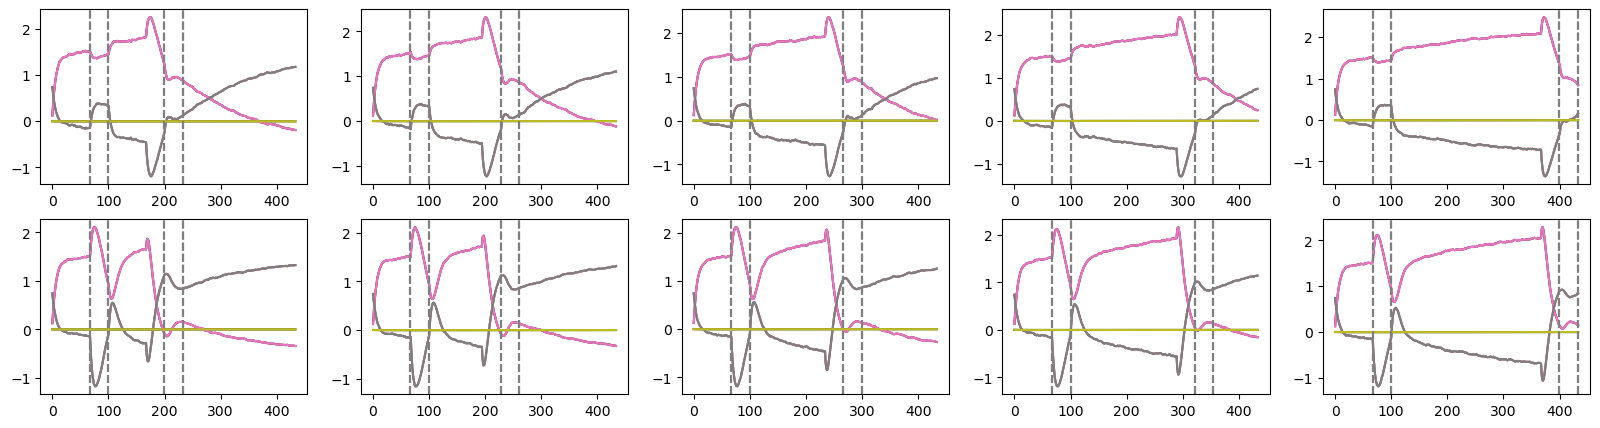

In [45]:
#view output for each sample-delay combo, averaged across all trials

f,ax=plt.subplots(2,5, figsize=(20,5))
with torch.no_grad():
    
    for sample in range(num_samps):
        for i,delay in enumerate(unique_delay_times):
            inds = torch.where((y == sample) & (test_on == delay))[0]
            
            for node in range(out_readout.size(2)):
                ax[sample,i].plot(out_readout[inds].mean(0))
                ax[sample,i].axvline(1000/15, linestyle='--', color='gray') #sample on
                ax[sample,i].axvline(1500/15, linestyle='--', color='gray') #sample on
                ax[sample,i].axvline(500/15+delay, linestyle='--', color='gray') #test on
                ax[sample,i].axvline(1000/15+delay, linestyle='--', color='gray') #test off

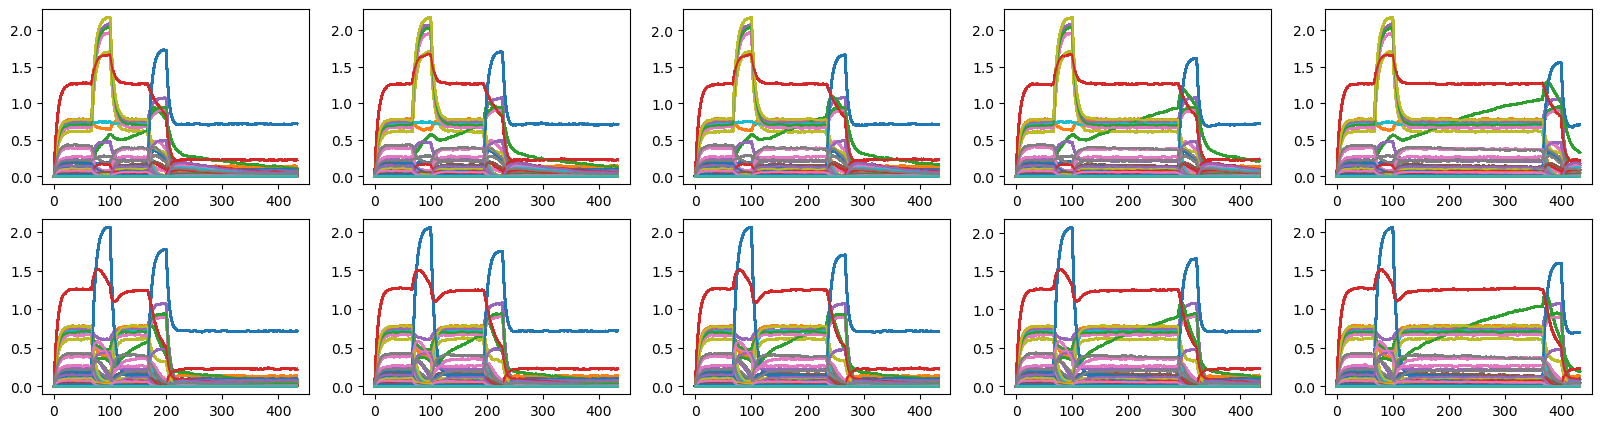

In [35]:
f,ax=plt.subplots(2,5, figsize=(20,5))
with torch.no_grad():
    
    for sample in range(num_samps):
        for i,delay in enumerate(unique_delay_times):
            inds = torch.where((y == sample) & (test_on == delay))[0]
            
            for node in range(out_hidden.size(2)):
                ax[sample,i].plot(out_hidden[inds].mean(0))

In [21]:
y

tensor([0, 0, 1,  ..., 0, 0, 1])

In [11]:
#returns activations for nodes and weights as trials * time * hidden-nodes matrix
with torch.no_grad():
    unique_delay_times = torch.unique(test_on)
    act_neur = []
    act_syn = []

    for i in unique_delay_times:
        act_vs_time_neur = []
        act_vs_time_syn = []

        for j in range(num_samps):                
            inds = torch.where((y == j) & (test_on == i))[0]

            mean_act_neur = out_hidden[inds].mean(0) #average for all hidden-layer nodes?
            mean_act_syn = w_hidden[inds].mean(0)

            act_vs_time_neur.append(mean_act_neur- mean_act_neur[int(1000/dt_ann)]) #not sure what the subtraction part means
            act_vs_time_syn.append(mean_act_syn - mean_act_syn[int(1000/dt_ann)])

        act_neur.append(act_vs_time_neur)
        act_syn.append(act_vs_time_syn)

In [12]:
unique_delay_times = [d.item() for d in torch.unique(test_on)]
samps = [0,1]

In [13]:
trial_d = {}
trial_d[0] = dict.fromkeys(unique_delay_times)
trial_d[1] = dict.fromkeys(unique_delay_times)
trial_d

{0: {166.0: None, 194.0: None, 233.0: None, 288.0: None, 366.0: None},
 1: {166.0: None, 194.0: None, 233.0: None, 288.0: None, 366.0: None}}

In [14]:
with torch.no_grad():
    for delay in unique_delay_times:
        for samp in range(num_samps): 
            inds = torch.where((y == samp) & (test_on == delay))[0]
            trial_d[samp][delay] = {'inds' : inds}
trial_d

{0: {166.0: {'inds': tensor([  21,   36,   45,   58,   59,   73,   79,   82,   97,  119,  133,  134,
            139,  163,  168,  178,  192,  218,  222,  223,  231,  235,  236,  239,
            244,  272,  278,  289,  299,  300,  301,  316,  324,  334,  337,  341,
            342,  357,  358,  362,  365,  367,  377,  379,  388,  405,  431,  446,
            473,  475,  498,  517,  519,  526,  535,  544,  554,  569,  578,  594,
            611,  613,  614,  615,  621,  658,  666,  673,  674,  685,  698,  699,
            700,  714,  718,  732,  733,  740,  741,  752,  753,  758,  771,  779,
            788,  816,  834,  850,  873,  906,  912,  918,  919,  925,  936,  940,
            946,  951,  954,  965,  984,  998, 1004, 1007])},
  194.0: {'inds': tensor([   1,   17,   28,   29,   33,   52,   66,   69,   71,   74,   81,  105,
            124,  142,  152,  176,  195,  200,  209,  221,  227,  247,  257,  275,
            281,  307,  310,  314,  315,  319,  321,  326,  332,  344,  371

In [15]:
sorted_inds

NameError: name 'sorted_inds' is not defined

In [ ]:
sorted_inds[:10]

In [ ]:
# look at top 10 most active hidden nodes for each trial
with torch.no_grad():
    
    for delay in unique_delay_times:
        for samp in range(num_samps):
            
            inds = trial_d[samp][delay]['inds']
            Hout = out_hidden[inds,:,:]
            meanHout = Hout.mean(dim=1)  #averaged across trial time
    
            active_nodes = []
            inactive_nodes = []
        
            for trial in range(meanHout.shape[0]):
                hidden_acts = meanHout[trial,:]
                sorted_inds = np.argsort(hidden_acts)  #get indices of 10 highest activations
                high_act_inds = [i.item() for i in sorted_inds[-10:]]
                low_act_inds = [i.item() for i in sorted_inds[:10]]
                active_nodes += high_act_inds
                inactive_nodes += low_act_inds
            
            trial_d[samp][delay]['active_nodes'] = set(active_nodes)
            trial_d[samp][delay]['inactive_nodes'] = set(inactive_nodes)

In [ ]:
for samp in range(num_samps):
    for delay in unique_delay_times:
        print('samp:', samp)
        print('delay:', delay)
        print('active_nodes:', trial_d[samp][delay]['active_nodes'])
        #print('inactive_nodes:', trial_d[samp][delay]['inactive_nodes'])
        print('')

In [ ]:
out_hidden.mean(dim=2).size()

In [ ]:
# time * nodes
with torch.no_grad():
    plt.figure(figsize=(10,2))
    plt.imshow(out_hidden.mean(dim=0).T, cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
# trials * nodes
with torch.no_grad():
    plt.figure(figsize=(15,2))
    plt.imshow(out_hidden.mean(dim=1).T, cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
# trials * time
with torch.no_grad():
    plt.figure(figsize=(10,3))
    plt.imshow(out_hidden.mean(dim=2).T, cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
#get trial indices sorted by delay
sorted_trial_inds0 = []
sorted_trial_inds1 = []
for delay in unique_delay_times: #sort by delay length
    sorted_trial_inds0 += [x.item() for x in trial_d[0][delay]['inds']]
    sorted_trial_inds1 += [x.item() for x in trial_d[1][delay]['inds']]
    
sorted_out_hidden = out_hidden.clone().detach()
sorted_out_hidden0 = torch.stack([sorted_out_hidden[trial,:,:] for trial in sorted_trial_inds0])
sorted_out_hidden1 = torch.stack([sorted_out_hidden[trial,:,:] for trial in sorted_trial_inds1])
all_sorted_hidden = torch.cat((sorted_out_hidden0, sorted_out_hidden1))

In [ ]:
# trials * time, sorted by sample and delay length
with torch.no_grad():
    plt.figure(figsize=(10,3))
    plt.imshow(all_sorted_hidden.mean(dim=2).T, cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
# time * nodes
with torch.no_grad():

    # sorted_trial_inds = []
    f,ax = plt.subplots(2,5, figsize=(15,5), sharex=True, sharey=True)

    for samp in range(num_samps):
        for x,delay in enumerate(unique_delay_times):
            
            inds = trial_d[samp][delay]['inds']
            act = torch.stack([out_hidden[trial,:,:] for trial in inds])
            active_nodes = list(trial_d[samp][delay]['active_nodes'])
            img = ax[samp,x].imshow(act[:,:,active_nodes].mean(dim=0).T, cmap='hot', interpolation='nearest')
            #img = ax[samp,x].imshow(act.mean(dim=0).T, cmap='hot', interpolation='nearest')
            ax[samp,x].set_aspect('auto') #so x axis doesn't get squished

In [ ]:
# time * nodes
with torch.no_grad():

    # sorted_trial_inds = []
    f,ax = plt.subplots(1,5, figsize=(15,3), sharex=True, sharey=True)

    for x,delay in enumerate(unique_delay_times):

        inds0 = trial_d[0][delay]['inds']
        act0 = torch.stack([out_hidden[trial,:,:] for trial in inds0])
        active_nodes0 = list(trial_d[0][delay]['active_nodes'])
        
        inds1 = trial_d[1][delay]['inds']
        act1 = torch.stack([out_hidden[trial,:,:] for trial in inds1])
        active_nodes1 = list(trial_d[1][delay]['active_nodes'])
        
        b = np.array([len(act0), len(act1)])
        min_trials = b.min()-1
        all_active = list(set(active_nodes0+active_nodes1))
        
        diff = act0[:min_trials,:,:] - act1[:min_trials,:,:]
        
        img = ax[x].imshow(diff[:,:,all_active].mean(dim=0).T, cmap='bwr', interpolation='nearest')
        #img = ax[samp,x].imshow(act.mean(dim=0).T, cmap='hot', interpolation='nearest')
        ax[x].set_aspect('auto') #so x axis doesn't get squished
        ax[x].set_title(delay)

In [ ]:
# time * nodes
with torch.no_grad():

    # sorted_trial_inds = []
    f,ax = plt.subplots(1,5, figsize=(15,3), sharex=True, sharey=True)

    for x,delay in enumerate(unique_delay_times):

        inds0 = trial_d[0][delay]['inds']
        act0 = torch.stack([out_hidden[trial,:,:] for trial in inds0])
        active_nodes0 = list(trial_d[0][delay]['active_nodes'])
        
        inds1 = trial_d[1][delay]['inds']
        act1 = torch.stack([out_hidden[trial,:,:] for trial in inds1])
        
        b = np.array([len(act0), len(act1)])
        min_trials = b.min()-1
        
        diff = act0[:min_trials,:,:] - act1[:min_trials,:,:]
        
        img = ax[x].imshow(diff[:,:,:].mean(dim=0).T, cmap='bwr', interpolation='nearest')
        #img = ax[samp,x].imshow(act.mean(dim=0).T, cmap='hot', interpolation='nearest')
        ax[x].set_aspect('auto') #so x axis doesn't get squished
        ax[x].set_title(delay)

In [ ]:
E_I = model.rnn.D.sum(axis=0) #get E/I as list of +1's and -1's

In [ ]:
F_inds = model.rnn.facil_syn_inds

In [ ]:
D_inds = model.rnn.depress_syn_inds

In [ ]:
ex_bool = E_I==1
in_bool = E_I==-1

In [ ]:
ex_bool[:50] = False
ex_fac_bool = ex_bool

In [ ]:
ex_bool[50:] = False
ex_dep_bool = ex_bool

In [ ]:
in_bool[:50] = False
in_fac_bool = in_bool

In [ ]:
in_bool[50:] = False
in_dep_bool = in_bool

In [ ]:
#get trial indices sorted by delay
sorted_trial_inds0 = []
sorted_trial_inds1 = []
for delay in unique_delay_times: #sort by delay length
    sorted_trial_inds0 += [x.item() for x in trial_d[0][delay]['inds']]
    sorted_trial_inds1 += [x.item() for x in trial_d[1][delay]['inds']]
    
sorted_out_hidden = out_hidden.clone().detach()
sorted_out_hidden0 = torch.stack([sorted_out_hidden[trial,:,:] for trial in sorted_trial_inds0])
sorted_out_hidden1 = torch.stack([sorted_out_hidden[trial,:,:] for trial in sorted_trial_inds1])
all_sorted_hidden = torch.cat((sorted_out_hidden0, sorted_out_hidden1))

In [ ]:
# trials * time, sorted by sample and delay length
with torch.no_grad():
    plt.figure(figsize=(10,3))
    plt.imshow(all_sorted_hidden[:,:,E_I_bool].mean(dim=2).T, cmap='hot', interpolation='nearest')
    plt.show()

In [ ]:
model.rnn.weight_ho